# Kaggle's M5 forecasting Competition

Author: `Miguel Trejo Marrufo`

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
import seaborn as sns 
import statsmodels.formula.api as smf
import statsmodels.api         as sm
import rpy2
from sklearn.utils import shuffle
from scipy.stats import yeojohnson, yeojohnson_normplot, probplot, boxcox
from statsmodels.stats.outliers_influence import OLSInfluence
from preprocess import pp_transforms, pp_tests, pp_processes
from scripts import arima, sem, holt, holt_winters
from models import AutoRegressive
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Display all columns
pd.set_option('display.max_columns', None)

# Use a ggplot style for graphics
plt.style.use('ggplot')

C:\Users\amtre\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\amtre\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


***Notes***

1. ```dt_complementary``` merges the original calendar and price data to know the ```date``` when the ```product_id``` of the ```store_id``` was saled at. Additionaly to know if they were particular events like ```SNAP``` purchases or major events, check the documentation.

2. ```dt_sales_s```. In case you don't have enough RAM take initial n rows of the original dataframe and shuffle the data, because it is ordered.

3. ```dt_sales_melt```. Melt the dataframe so that each sale by product can be seen as row.

4. ```dt_work```. Merges ```dt_sales_melt``` with ```dt_complementary``` to know for each day of sale the price and relevant events associated to that day.

## 1. `Process Data`

In [2]:
# Load data
files = ['data/calendar.csv', 'data/sales_train_validation.csv', 'data/sell_prices.csv']
data = [pd.read_csv(f) for f in files]
dt_calendar, dt_sales, dt_prices = data

# Merge calendar and prices
dt_complementary = dt_prices.merge(dt_calendar, how='left', on='wm_yr_wk')
del dt_prices
del dt_calendar

In [3]:
# Count the number of zeros in data 
dt_sales['num_zeros'] = (dt_sales == 0).sum(axis=1)


# Transform date variable to datetime
dt_complementary.date = pd.to_datetime(dt_complementary.date)

# Append the first day of sales to each item 
first_date = dt_complementary.groupby(['store_id','item_id']).agg({'date':'min'}).reset_index().rename(columns={'date':'date_first_sale'})
dt_sales = dt_sales.merge(first_date, how='left', on=['store_id','item_id'])

# Delete data to save RAM
del first_date

# Difference in days between date_first_sales and d_1
dt_sales['since_d_1'] = dt_sales.date_first_sale - pd.to_datetime('2011-01-29')
dt_sales['since_d_1'] = dt_sales['since_d_1'].apply(lambda x: x.days)

# Percentage of zeros since first day of sale
dt_sales['%_zeros_of_total'] = round(((dt_sales.num_zeros - dt_sales.since_d_1) / (1913 - dt_sales.since_d_1)) * 100, 2)

In [4]:
def perc_bin(num:int):
    if num <= 10:
        output = 'perc_bin_1'
    elif num <= 20:
        output = 'perc_bin_2'
    elif num <= 30:
        output = 'perc_bin_3'
    elif num <= 40:
        output = 'perc_bin_4'
    elif num <= 50:
        output = 'perc_bin_5'
    elif num <= 60:
        output = 'perc_bin_6'
    elif num <= 70:
        output = 'perc_bin_7'
    elif num <= 80:
        output = 'perc_bin_8'
    elif num <= 90:
        output = 'perc_bin_9'
    else:
        output = 'perc_bin_10'
    return output

dt_sales['perc_zeros_bin'] = dt_sales['%_zeros_of_total'].apply(lambda x: perc_bin(x))

## 2. `First Submission` (Avg of the last years for the same date)

The last 5 years observation for the same period of Juin-July are 

+ 2011 ---> 143:170
+ 2012 ---> 509:536
+ 2013 ---> 874:901
+ 2014 ---> 1239:1266
+ 2015 ---> 1604:1631

In [111]:
submission = {}

for idx, row in dt_sales.iterrows():
    idt, sales = row[0], row[6:1919]
    data = (s_2011, s_2012, s_2013, s_2014, s_2015) = sales[142:170], sales[508:536], sales[873:901], sales[1238:1266], sales[1603:1631]
    data = (d for d in data if all(d == 0) == False)
    output = [int(np.mean(e) + .5) if np.mean(e) == .5 else int(round(np.mean(e))) for e in zip(*data)]
    if len(output) == 0:
        output = [0] * 28
    submission[idt] = output
    
submission = pd.DataFrame.from_dict(submission, orient = 'index').reset_index()
submission.columns = ['id','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20','F21','F22','F23','F24','F25','F26','F27','F28']

In [134]:
# Read sample_submission to replace values 
sample_submission = pd.read_csv('data/sample_submission.csv')

# Replace values in sample_submission
for idx, row in submission.iterrows():
    item = row[0]
    sample_submission.loc[sample_submission.id == item, 'F1':] = list(row[1:])
    
# Save to csv 
sample_submission.to_csv("first_submission_AMTM.csv", index=False)

## 3. Stratified Sampling 

In [5]:
# Number of elements by each bin of zeros
bin_elements = dt_sales.groupby('perc_zeros_bin').agg({'id':'count'})

# Sample one-third of each bin 
sales_sampled = dt_sales.groupby('perc_zeros_bin', group_keys=False).apply(lambda x: x.sample(int(bin_elements.loc[x.perc_zeros_bin.unique()[0],'id']/3)))

## 4. Forecasting with Exponential Smoothing Models

In [6]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro 

# Activate automatic conversion
pandas2ri.activate()

# R libraries
forecast = importr('forecast')
base = importr('base')

# R functions
ets = forecast.ets
forecast_function = forecast.forecast

# R objects 
ts=ro.r('ts')

In [147]:
# Model with prior 180 days of data to train and 30 days to test
ets_model = {}

for index,row in sales_sampled.iterrows():
    item_id, since_d1, zero_bin = row[0], row[-3], row[-1]
    
    # Split data
    sales = row[6+since_d1:-5]
    train, test = sales[-210:-30], sales[-30:-1]
    
    # Fit an ets model
    fit = ets(ro.IntVector(train), opt_crit="mae")
    model = fit.rx2('method')
    
    # Forecast 
    result = forecast_function(fit, h=29)
    point_forecast = np.array(result.rx2('mean'))
    
    # Evaluation metrics
    rmse = np.sqrt(((point_forecast - test)**2).mean())
    
    ets_model[item_id] = [str(model), rmse, zero_bin]
    
    
ets_180 = pd.DataFrame.from_dict(ets_model, orient='index').reset_index()
ets_180.columns = ['id', 'model', 'rmse', 'perc_zeros_bin']

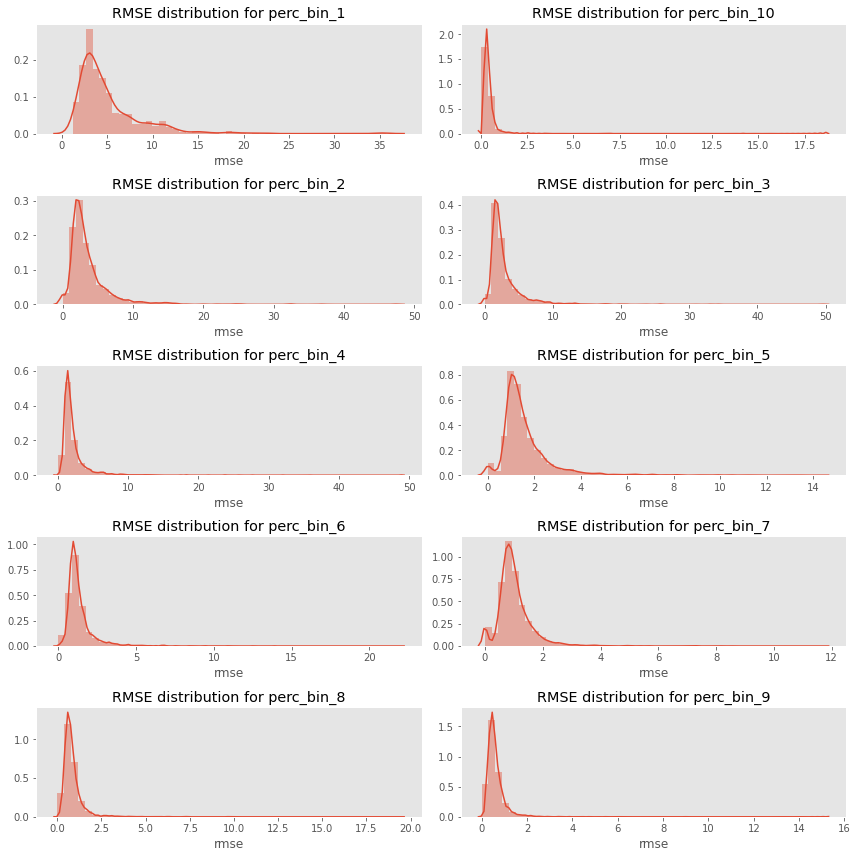

In [149]:
plt.figure(figsize=(12,12))

for idx, col in enumerate(ets_180.perc_zeros_bin.unique()):
    df = ets_180[ets_180.perc_zeros_bin == col]
    plt.subplot(5,2,idx+1)
    plt.title(f"RMSE distribution for {col}")
    plt.grid(False)
    sns.distplot(df.rmse)
    
plt.tight_layout(1)

## 5. ETS models submission

In [156]:
submission_ets = {}

for index,row in dt_sales.iterrows():
    item_id, since_d1, zero_bin = row[0], row[-3], row[-1]
    
    # Split data
    sales = row[6+since_d1:-5]
    train = sales[-180:-1]
    
    # Fit an ets model
    fit = ets(ro.IntVector(train), opt_crit="mae")
    model = fit.rx2('method')
    
    # Forecast 
    result = forecast_function(fit, h=28)
    point_forecast = np.array(result.rx2('mean'))
    
    submission_ets[item_id] = point_forecast
    
ets_submission = pd.DataFrame.from_dict(submission_ets, orient='index').reset_index().rename(columns={'index':'item_id'})

In [187]:
# Read sample_submission to replace values 
first_submission = pd.read_csv('first_submission_AMTM.csv')

# Replace values in sample_submission
for idx, row in ets_submission.iterrows():
    item, sales = row[0], row[1:]
    first_submission.loc[first_submission.id == item, 'F1':] = list(np.around(sales.astype(np.double),0))
  
# Save to csv 
first_submission.to_csv("ets_submission_AMTM.csv", index=False)

## 6. Interpolation 

In [63]:
# R libraries
imputeTS = importr('imputeTS')

# R functions
na_seadec, na_seasplit, na_ma, na_kalman = imputeTS.na_seadec, imputeTS.na_seasplit, imputeTS.na_ma, imputeTS.na_kalman

In [68]:
bins = ['perc_bin_1', 'perc_bin_2']
sampled_bins = sales_sampled[sales_sampled.perc_zeros_bin.isin(bins)]

ets_180_interpolation = {}

for index,row in sampled_bins.iterrows():
    item_id, since_d1, zero_bin = row[0], row[-3], row[-1]
    
    # Split data
    sales = row[6+since_d1:-5]
    train, test = sales[-180:-29], sales[-29:-1]
    
    # Replace zeros with NA's
    train = train.replace(to_replace=0, value=np.nan)    
    try:
        train = na_seasplit(ts(train), algorithm="kalman")
    except rpy2.rinterface.RRuntimeError as e:
        print(e)
        train = na_ma(ts(train))
    
    # Fit an ets model
    try:
        fit = ets(ts(train), opt_crit="mae")
    except rpy2.rinterface.RRuntimeError as e:
        print(e)
        continue
    
    # Method fitted
    model = fit.rx2('method')
    
    # Forecast 
    result = forecast_function(fit, h=28)
    point_forecast = np.array(result.rx2('mean'))
    
    # Evaluation metrics
    rmse = np.sqrt(((point_forecast - test)**2).mean())
    
    ets_180_interpolation[item_id] = [str(model), rmse, zero_bin]   

Error in min(y) : invalid 'type' (list) of argument

Error in min(y) : invalid 'type' (list) of argument

Error in optim(init[mask], getLike, method = "L-BFGS-B", lower = rep(0,  : 
  L-BFGS-B needs finite values of 'fn'



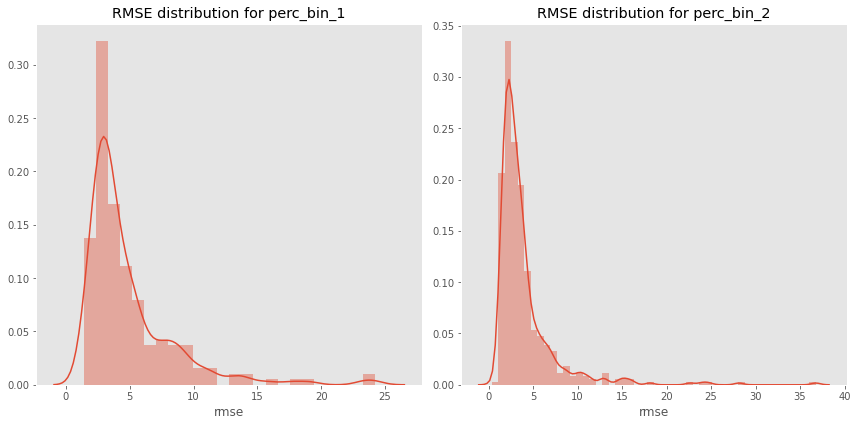

In [66]:
ets_180_interpolation = pd.DataFrame.from_dict(ets_180_interpolation, orient='index').reset_index()
ets_180_interpolation.columns = ['id', 'model', 'rmse', 'perc_zeros_bin']

plt.figure(figsize=(12,6))

for idx, col in enumerate(ets_180_interpolation.perc_zeros_bin.unique()):
    df = ets_180_interpolation[ets_180_interpolation.perc_zeros_bin == col]
    plt.subplot(1,2,idx+1)
    plt.title(f"RMSE distribution for {col}")
    plt.grid(False)
    sns.distplot(df[df.rmse < 40].rmse)
    
plt.tight_layout(1)

## 7. Forecast with Interpolation

In [70]:
submission_ets_interpolation = {}
bins = ['perc_bin_1', 'perc_bin_2']

for index,row in dt_sales[dt_sales.perc_zeros_bin.isin(bins)].iterrows():
    item_id, since_d1, zero_bin = row[0], row[-3], row[-1]
    
    # Split data
    sales = row[6+since_d1:-5]
    train = sales[-180:-1]
    
    # Replace zeros with NA's
    train = train.replace(to_replace=0, value=np.nan)    
    try:
        train = na_seasplit(ts(train), algorithm="kalman")
    except rpy2.rinterface.RRuntimeError as e:
        print(e)
        train = na_ma(ts(train))
    
    # Fit an ets model
    try:
        fit = ets(ts(train), opt_crit="mae")
    except rpy2.rinterface.RRuntimeError as e:
        print(e)
        continue
    
    # Model fitted
    model = fit.rx2('method')
    
    # Forecast 
    result = forecast_function(fit, h=28)
    point_forecast = np.array(result.rx2('mean'))
    
    submission_ets_interpolation[item_id] = point_forecast
    
submission_ets_interpolation = pd.DataFrame.from_dict(submission_ets_interpolation, orient='index').reset_index().rename(columns={'index':'item_id'})

Error in optim(init[mask], getLike, method = "L-BFGS-B", lower = rep(0,  : 
  L-BFGS-B needs finite values of 'fn'

Error in min(y) : invalid 'type' (list) of argument

Error in optim(init[mask], getLike, method = "L-BFGS-B", lower = rep(0,  : 
  L-BFGS-B needs finite values of 'fn'

Error in optim(init[mask], getLike, method = "L-BFGS-B", lower = rep(0,  : 
  L-BFGS-B needs finite values of 'fn'

Error in min(y) : invalid 'type' (list) of argument

Error in min(y) : invalid 'type' (list) of argument

Error in min(y) : invalid 'type' (list) of argument

Error in optim(init[mask], getLike, method = "L-BFGS-B", lower = rep(0,  : 
  L-BFGS-B needs finite values of 'fn'

Error in min(y) : invalid 'type' (list) of argument

Error in min(y) : invalid 'type' (list) of argument



In [97]:
# Read sample_submission to replace values 
third_submission = pd.read_csv("ets_submission_AMTM.csv")

# Replace values in sample_submission
for idx, row in submission_ets_interpolation.iterrows():
    sales = row[1:]
    third_submission.loc[third_submission.id == row['item_id'], 'F1':] = list(np.around(sales.astype(np.double),0))

# Verify
print(third_submission.shape)
    
# Save to csv 
third_submission.to_csv("ets_submission_interpolation_AMTM.csv", index=False)

(60980, 29)


## 8. Forecast with ARIMA models 

In [10]:
auto_arima, checkresiduals, dm_test = forecast.auto_arima, forecast.checkresiduals, forecast.dm_test

In [ ]:
from rpy2.robjects import numpy2ri
numpy2ri.activate()
submission_mdl_comparison = {}
bins = ['perc_bin_1', 'perc_bin_2']
iterable = dt_sales[dt_sales.perc_zeros_bin.isin(bins)]

for index,row in tqdm(iterable.iterrows(), total=iterable.shape[0]):
    item_id, since_d1, zero_bin = row[0], row[-3], row[-1]
    
    # Split data
    sales = row[6+since_d1:-5]
    train = sales[-360:]
    
    # Replace zeros with NA's
    train = train.replace(to_replace=0, value=np.nan)  
    train = ro.FloatVector(train)
    
    try:
        train = na_kalman(ts(train), smooth=True, maxgap=3)
    except rpy2.rinterface.RRuntimeError as e:
        train = na_ma(ts(train), maxgap=3)
        print(e)
    
    train = np.array(train)
    train = train[~np.isnan(train)]
    
    # Control the variance 
    train_log = np.log(train + 1)
    
    # Fit an ets model
    try:
        mdl_ets = ets(ts(train_log), opt_crit="mae")
        ets_residuals = mdl_ets.rx2('residuals')
    except rpy2.rinterface.RRuntimeError as e:
        print(e)
    
    # Fit an arima model 
    try:
        mdl_arima = auto_arima(ts(train_log), stepwise=False, approximation=False)
        arima_residuals = mdl_arima.rx2('residuals')
    except rpy2.rinterface.RRuntimeError as e:
        print(e)
    
    # Diebold Mariano test
    mdl_comparison = dm_test(ets_residuals, arima_residuals, alternative="greater", h=28)
    dm_p_value = np.array(mdl_comparison.rx2('p.value'))[0] 
    
    # Model selection: Null Hypothesis is ETS model is better. Alternative is Arima is better
    if dm_p_value < 0.05:
        point_forecast = forecast_function(mdl_arima, h=28)
        model = mdl_arima.rx2('arma')
    else:
        point_forecast = forecast_function(mdl_ets, h=28) 
        model = mdl_ets.rx2('method')
        
    # Undo logarithmic transformation     
    point_forecast = np.array(point_forecast.rx2('mean'))
    point_forecast = np.exp(point_forecast)
    
    # Visualize Forecast
    plt.figure(figsize=(12,6))
    plt.plot(np.array(range(len(train))),train, color="b", label="Time Series")
    plt.plot(np.array(range(len(train),len(train) + len(point_forecast))),point_forecast, color="r", label="Forecast")
    plt.legend()
    plt.title(f"Forecast with {model} for {item_id}")
    plt.grid(False)
    plt.show()      
    
    submission_mdl_comparison[item_id] = point_forecast